## Exploring text data

If you haven't installed wordcloud yet: run "!pip install wordcloud" in a jupyter notebook cell to install the library.

In [1]:
#Imports
import re
import unicodedata
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from env import get_connection

import acquire as a
import prepare as p

In [2]:
#Get SQL database url
url = get_connection('spam_db')

In [3]:
#Define SQL query
query = '''
        SELECT *
        FROM spam
        '''

In [4]:
#Read SQL
df = pd.read_sql(query, url, index_col='id')
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
#Value counts of labels
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [6]:
#Define function to clean up text data
def clean_text(text, extra_stopwords=['r', 'u', '2', 'ltgt']):
    
    wnl = nltk.stem.WordNetLemmatizer()
    
    stopwords = nltk.corpus.stopwords.words('english') + extra_stopwords
    
    clean_text = (unicodedata.normalize('NFKD', text)
                   .encode('ascii', 'ignore')
                   .decode('utf-8', 'ignore')
                   .lower())
    
    words = re.sub(r'[^\w\s]', '', clean_text).split()
    
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [7]:
#Clean the text data by label
ham_words = clean_text(' '.join(df[df['label'] == 'ham']['text']))
spam_words = clean_text(' '.join(df[df['label'] == 'spam']['text']))
all_words = clean_text(' '.join(df['text']))

In [8]:
#Save the value counts of each series to a variable
ham_counts = pd.Series(ham_words).value_counts()
spam_counts = pd.Series(spam_words).value_counts()
all_counts = pd.Series(all_words).value_counts()

In [9]:
#Check
spam_counts.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [10]:
#Combine the value counts into one dataframe
word_freq = pd.concat([ham_counts, spam_counts, all_counts], axis=1)
word_freq.head()

,0,1,2
im,449.0,13.0,462
get,314.0,83.0,397
go,273.0,31.0,304
ok,272.0,5.0,277
dont,257.0,22.0,279


In [11]:
#Check for nulls
word_freq.isna().sum()

0    1918
1    6086
2       0
dtype: int64

In [12]:
#Rename columns and fill null values
word_freq.columns = ['ham', 'spam', 'all']
word_freq.fillna(0, inplace=True)
word_freq.head()

,ham,spam,all
im,449.0,13.0,462
get,314.0,83.0,397
go,273.0,31.0,304
ok,272.0,5.0,277
dont,257.0,22.0,279


In [13]:
#Check datatypes of columns
word_freq.dtypes

ham     float64
spam    float64
all       int64
dtype: object

In [14]:
#Recast all columns as integers
word_freq = word_freq.astype('int')
word_freq.head()

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279


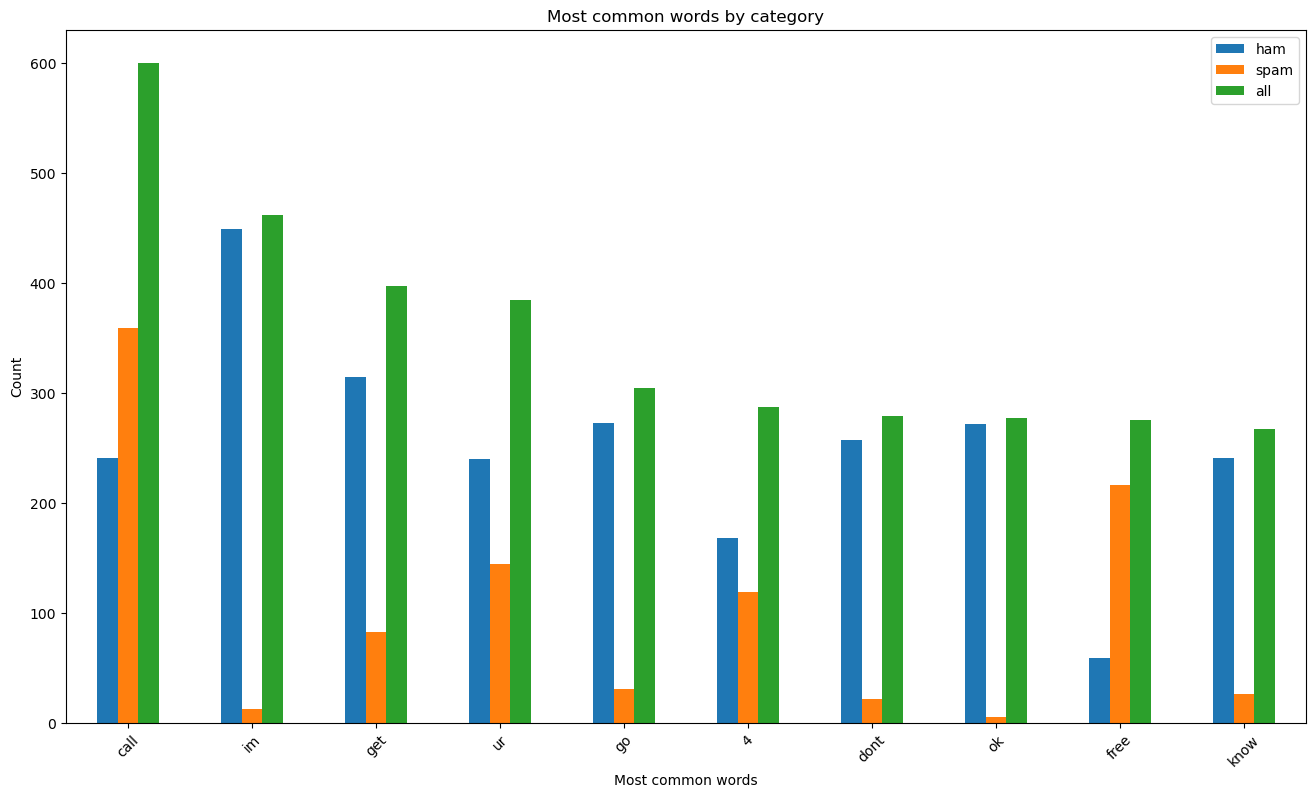

In [15]:
#Plot the most frequent words and color by label
word_freq.sort_values('all', ascending=False).head(10).plot.bar(figsize=(16, 9))
plt.title('Most common words by category')
plt.ylabel('Count')
plt.xlabel('Most common words')
plt.xticks(rotation=45)
plt.show()

In [16]:
#Calculate percentage of all words by label
word_freq['pct_ham'] = word_freq['ham'] / word_freq['all'] * 100
word_freq['pct_spam'] = word_freq['spam'] / word_freq['all'] * 100
word_freq.head()

,ham,spam,all,pct_ham,pct_spam
im,449,13,462,97.186147,2.813853
get,314,83,397,79.093199,20.906801
go,273,31,304,89.802632,10.197368
ok,272,5,277,98.194946,1.805054
dont,257,22,279,92.114695,7.885305


In [17]:
#Look at the highest percent ham words
word_freq[word_freq['ham'] > 200].sort_values('pct_ham', ascending=False)

,ham,spam,all,pct_ham,pct_spam
ill,236,1,237,99.578059,0.421941
ok,272,5,277,98.194946,1.805054
come,242,5,247,97.975709,2.024291
im,449,13,462,97.186147,2.813853
got,231,7,238,97.058824,2.941176
good,223,12,235,94.893617,5.106383
like,232,13,245,94.693878,5.306122
dont,257,22,279,92.114695,7.885305
time,213,19,232,91.810345,8.189655
know,241,26,267,90.262172,9.737828


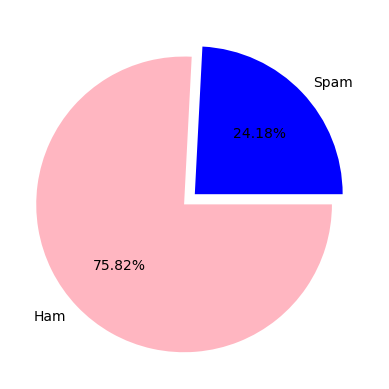

In [18]:
spam_count = word_freq['spam'].sum()
ham_count = word_freq['ham'].sum()
values = (spam_count, ham_count)
labels = ('Spam', 'Ham')
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.pie(values, labels = labels, autopct = "%.2f%%", explode = (0, 0.1), colors = ('blue', 'lightpink'))
plt.show()

In [19]:
#Highest percent spam words
word_freq[word_freq['spam'] > 100].sort_values('pct_spam', ascending=False)

,ham,spam,all,pct_ham,pct_spam
claim,0,115,115,0.000000,100.000000
txt,13,150,163,7.975460,92.024540
mobile,15,135,150,10.000000,90.000000
free,59,216,275,21.454545,78.545455
stop,40,113,153,26.143791,73.856209
reply,43,102,145,29.655172,70.344828
text,77,137,214,35.981308,64.018692
call,241,359,600,40.166667,59.833333
4,168,119,287,58.536585,41.463415
ur,240,144,384,62.500000,37.500000


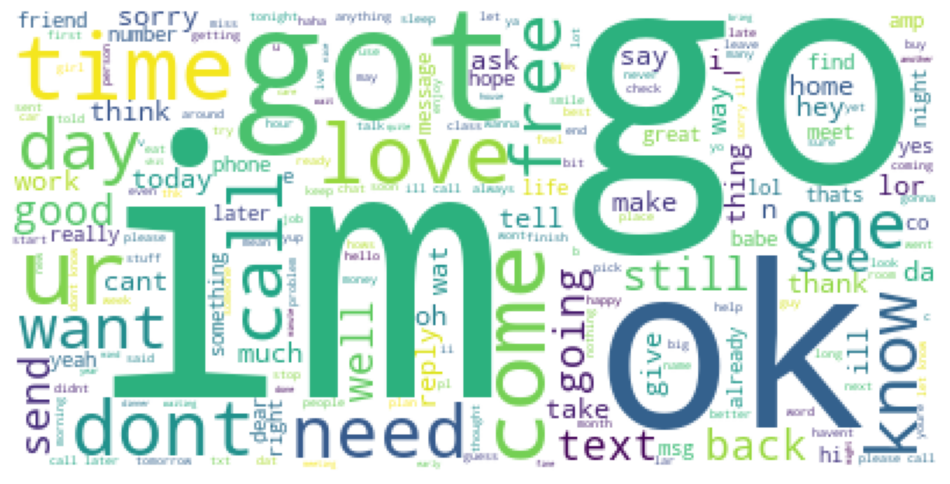

In [20]:
#Word cloud
all_cloud = WordCloud(background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(12, 8))
plt.imshow(all_cloud)
plt.axis('off')
plt.show()

In [21]:
#Bigrams!
ham_bigrams = pd.Series(nltk.ngrams(ham_words, 2))
ham_bigrams.head()

0          (go, jurong)
1       (jurong, point)
2        (point, crazy)
3    (crazy, available)
4    (available, bugis)
dtype: object

In [22]:
#Retrieve the 10 most frequent bigrams
top_ham_bigrams = ham_bigrams.value_counts().head(10)
top_ham_bigrams

(call, later)      52
(ill, call)        48
(let, know)        42
(sorry, ill)       39
(dont, know)       32
(good, morning)    31
(new, year)        30
(take, care)       26
(im, going)        24
(ok, lor)          22
dtype: int64

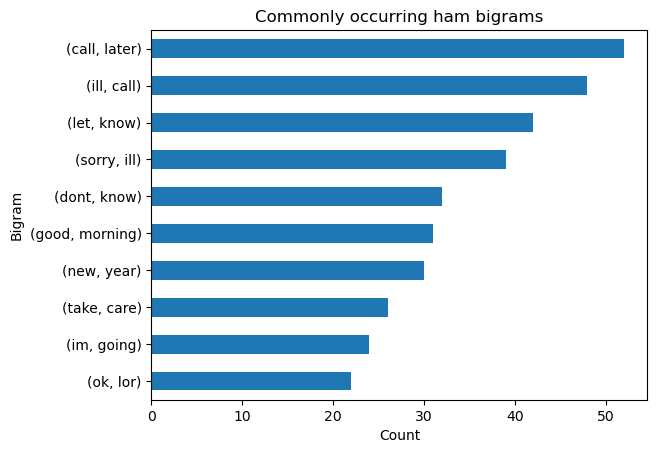

In [23]:
#Plot
top_ham_bigrams.plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Commonly occurring ham bigrams')
plt.show()

In [24]:
#Make spam bigrams
spam_bigrams = pd.Series(nltk.ngrams(spam_words, 2))
spam_bigrams.head()

0    (free, entry)
1    (entry, wkly)
2     (wkly, comp)
3      (comp, win)
4        (win, fa)
dtype: object

In [25]:
#Return the 10 most frequent spam bigrams
top_spam_bigrams = spam_bigrams.value_counts().head(10)
top_spam_bigrams

(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
(prize, guaranteed)    22
(send, stop)           19
(selected, receive)    19
(await, collection)    19
(every, week)          19
dtype: int64

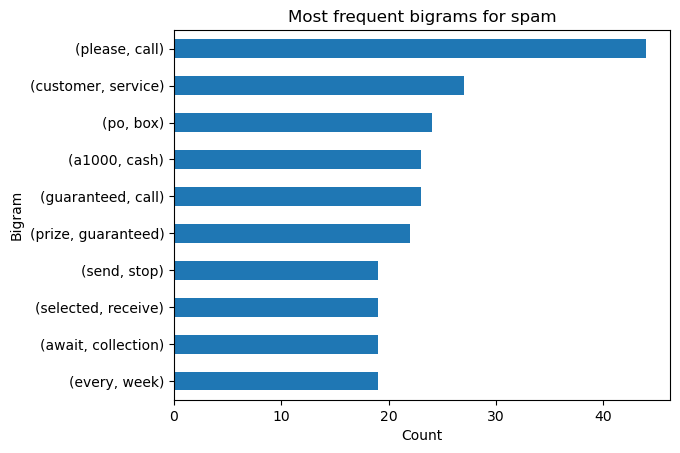

In [26]:
#Plot
top_spam_bigrams.plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most frequent bigrams for spam')
plt.show()

In [27]:
ham_trigrams = pd.Series(nltk.ngrams(ham_words, 3))
ham_trigrams.head()

0          (go, jurong, point)
1       (jurong, point, crazy)
2    (point, crazy, available)
3    (crazy, available, bugis)
4        (available, bugis, n)
dtype: object

In [28]:
top_ham_trigrams = ham_trigrams.value_counts().head(10)
top_ham_trigrams

(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(cant, pick, phone)     12
(right, pls, send)      12
(phone, right, pls)     12
(pick, phone, right)    12
(hi, hi, hi)            11
(x, x, x)                8
dtype: int64

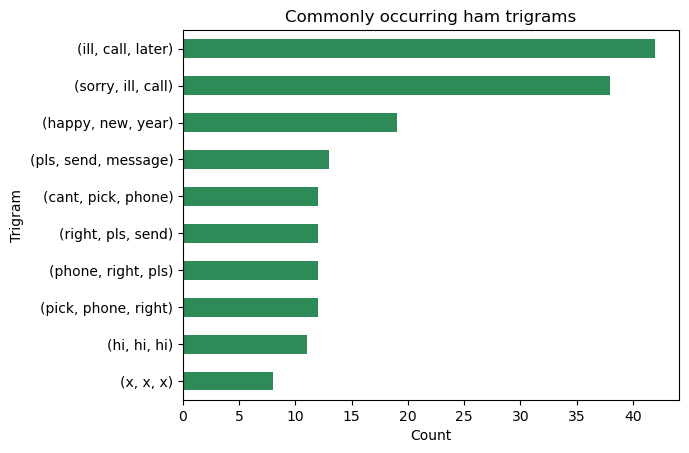

In [29]:
top_ham_trigrams.plot.barh(color = 'seagreen').invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.title('Commonly occurring ham trigrams')
plt.show()

In [30]:
spam_trigrams = pd.Series(nltk.ngrams(spam_words, 3))
spam_trigrams.head()

0    (free, entry, wkly)
1    (entry, wkly, comp)
2      (wkly, comp, win)
3        (comp, win, fa)
4         (win, fa, cup)
dtype: object

In [31]:
top_spam_trigrams = spam_trigrams.value_counts().head(10)
top_spam_trigrams

(prize, guaranteed, call)     21
(call, customer, service)     15
(land, line, claim)           14
(reply, call, 08000930705)    14
(private, 2003, account)      13
(2003, account, statement)    13
(camcorder, reply, call)      12
(guaranteed, a1000, cash)     12
(show, 800, unredeemed)       12
(urgent, trying, contact)     11
dtype: int64

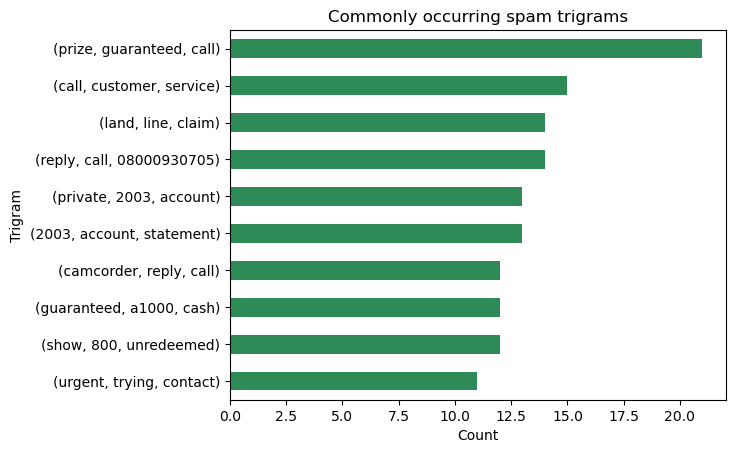

In [32]:
top_spam_trigrams.plot.barh(color = 'seagreen').invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.title('Commonly occurring spam trigrams')
plt.show()

In [33]:
codeup_df = a.get_blogs()
codeup_df

[{'title': 'Black Excellence in Tech: Panelist Spotlight – Wilmarie De La Cruz Mejia',
  'content': 'Black excellence in tech: Panelist Spotlight – Wilmarie De La Cruz Mejia\n\nCodeup is hosting a Black Excellence in Tech Panel in honor of Black History Month on February 22, 2023! To further celebrate, we’d like to spotlight each of our panelists leading up to the discussion to learn a bit about their respective experiences as black leaders in the tech industry!\xa0\xa0\nMeet Wilmarie!\nWilmarie De\xa0La Cruz Mejia is a current Codeup student on the path to becoming a Full-Stack Web Developer at our Dallas, TX campus.\xa0\nWilmarie is a veteran expanding her knowledge of programming languages and technologies on her journey with Codeup.\xa0\nWe asked Wilmarie to share more about her experience at Codeup. She shares, “I was able to meet other people who were passionate about coding and be in a positive learning environment.”\nWe hope you can join us on February 22nd to sit in on an insi

In [34]:
codeup_df = pd.DataFrame(codeup_df)

In [35]:
codeup_df.rename(columns={'content': 'original'}, inplace = True)

In [36]:
codeup_df

,title,original
0,Black Excellence in Tech: Panelist Spotlight –...,Black excellence in tech: Panelist Spotlight –...
1,Black excellence in tech: Panelist Spotlight –...,Black excellence in tech: Panelist Spotlight –...
2,Black excellence in tech: Panelist Spotlight –...,Black excellence in tech: Panelist Spotlight –...
3,Black excellence in tech: Panelist Spotlight –...,Black excellence in tech: Panelist Spotlight –...
4,Coding Bootcamp or Self-Learning? Which is Bes...,If you’re interested in embarking on a career ...
5,Codeup Among Top 58 Best Coding Bootcamps of 2023,Codeup is pleased to announce we have been ran...


In [39]:
wnl = nltk.stem.WordNetLemmatizer()

In [53]:
stopwords = nltk.corpus.stopwords.words('english')

In [69]:
new_df = codeup_df['lemmatized']
new_df

0    black excellence tech panelist spotlight wilma...
1    black excellence tech panelist spotlight steph...
2    black excellence tech panelist spotlight james...
3    black excellence tech panelist spotlight jeani...
4    youre interested embarking career tech likely ...
5    codeup pleased announce ranked among 58 best c...
Name: lemmatized, dtype: object

In [70]:
new_series = pd.Series(new_df)
new_series

0    black excellence tech panelist spotlight wilma...
1    black excellence tech panelist spotlight steph...
2    black excellence tech panelist spotlight james...
3    black excellence tech panelist spotlight jeani...
4    youre interested embarking career tech likely ...
5    codeup pleased announce ranked among 58 best c...
Name: lemmatized, dtype: object

In [71]:
new_series = new_series.to_string()

In [72]:
cleanup = (unicodedata.normalize('NFKD', new_series)
              .encode('ascii', 'ignore')
              .decode('utf-8', 'ignore')
              .lower())

In [73]:
cleanup

'0    black excellence tech panelist spotlight wilma...\n1    black excellence tech panelist spotlight steph...\n2    black excellence tech panelist spotlight james...\n3    black excellence tech panelist spotlight jeani...\n4    youre interested embarking career tech likely ...\n5    codeup pleased announce ranked among 58 best c...'

In [123]:
words = re.sub(r'[^\D\s]', '', cleanup).split()

In [111]:
words = [wnl.lemmatize(word) for word in words if word not in stopwords]

In [130]:
codey = pd.Series(words)

In [131]:
codey

0          black
1     excellence
2           tech
3       panelist
4      spotlight
5       wilma...
6          black
7     excellence
8           tech
9       panelist
10     spotlight
11      steph...
12         black
13    excellence
14          tech
15      panelist
16     spotlight
17      james...
18         black
19    excellence
20          tech
21      panelist
22     spotlight
23      jeani...
24         youre
25    interested
26     embarking
27        career
28          tech
29        likely
30           ...
31        codeup
32       pleased
33      announce
34        ranked
35         among
36          best
37          c...
dtype: object

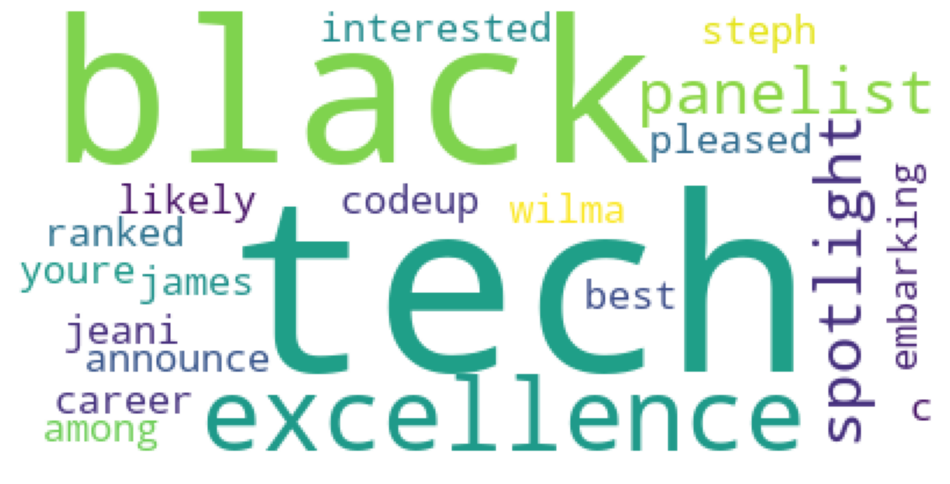

In [132]:
all_cloud = WordCloud(background_color='white').generate(' '.join(codey))
plt.figure(figsize=(12, 8))
plt.imshow(all_cloud)
plt.axis('off')
plt.show()

In [133]:
news_df = a.get_news_articles()
news_df

[{'category': 'business',
  'title': 'Income Tax Dept raids Edelweiss Group, search underway at Mumbai premises',
  'content': 'The Income Tax Department is conducting raids on Edelweiss Group, an investment and financial services company co-founded by Rashesh Shah and Venkat Ramaswamy, ANI reported on Thursday. Searches are underway at premises linked to the group in Mumbai, it added. Male employees asked to stay back in the office, while female employees have been sent back, Mirror Now reported.'},
 {'category': 'business',
  'title': 'Russia may run out of money in 2024, warns billionaire Deripaska',
  'content': 'Russian billionaire and aluminium tycoon Oleg Deripaska has warned that Russia may run out of money by 2024. He urged the government to stop interfering in business and instead create a predictable environment based on the rule of law to attract foreign investors. "If we change the rules of the game every year...or quarter...no one will have faith," he added.'},
 {'categor

In [134]:
news_df = pd.DataFrame(news_df)
news_df

,category,title,content
0,business,"Income Tax Dept raids Edelweiss Group, search ...",The Income Tax Department is conducting raids ...
1,business,"Russia may run out of money in 2024, warns bil...",Russian billionaire and aluminium tycoon Oleg ...
2,business,Coders losing jobs to ChatGPT will never happe...,Coders losing jobs to generative AI technologi...
3,business,Banks may shut on all Saturdays as IBA agrees ...,Banks may remain shut on all Saturdays in the ...
4,business,Pak central bank hikes key policy rate to high...,The State Bank of Pakistan (SBP) raised its ke...
...,...,...,...
95,entertainment,Could've avoided: Divya on Varun's reply to qu...,Varun Sood recently replied to a fan who asked...
96,entertainment,Told people to watch it alone: Daggubati on ab...,Rana Daggubati revealed that the makers decide...
97,entertainment,"Whenever I show middle finger, the film does v...",Discussing the success of 'Kabir Singh' and 'F...
98,entertainment,I'm an independent girl: Divya Agarwal on bein...,Actress Divya Agarwal reacted to being called ...


In [135]:
def prep_article_data(df, column, extra_words=[], exclude_words=[]):

    df['clean'] = df[column].apply(p.basic_clean)\
                            .apply(p.tokenize)\
                            .apply(p.remove_stopwords,
                                  extra_words=extra_words,
                                  exclude_words=exclude_words)
    
    df['stemmed'] = df['clean'].apply(p.stem)
    
    df['lemmatized'] = df['clean'].apply(p.lemmatize)
    
    return df[['title', column,'clean', 'stemmed', 'lemmatized']]

In [136]:
prep_article_data(news_df, 'content', extra_words = ['ha'], exclude_words = ['no'])

,title,content,clean,stemmed,lemmatized
0,"Income Tax Dept raids Edelweiss Group, search ...",The Income Tax Department is conducting raids ...,income tax department conducting raids edelwei...,incom tax depart conduct raid edelweiss group ...,income tax department conducting raid edelweis...
1,"Russia may run out of money in 2024, warns bil...",Russian billionaire and aluminium tycoon Oleg ...,russian billionaire aluminium tycoon oleg deri...,russian billionair aluminium tycoon oleg derip...,russian billionaire aluminium tycoon oleg deri...
2,Coders losing jobs to ChatGPT will never happe...,Coders losing jobs to generative AI technologi...,coders losing jobs generative ai technologies ...,coder lose job gener ai technolog like chatgpt...,coder losing job generative ai technology like...
3,Banks may shut on all Saturdays as IBA agrees ...,Banks may remain shut on all Saturdays in the ...,banks may remain shut saturdays future indian ...,bank may remain shut saturday futur indian ban...,bank may remain shut saturday future indian ba...
4,Pak central bank hikes key policy rate to high...,The State Bank of Pakistan (SBP) raised its ke...,state bank pakistan sbp raised key interest ra...,state bank pakistan sbp rais key interest rate...,state bank pakistan sbp raised key interest ra...
...,...,...,...,...,...
95,Could've avoided: Divya on Varun's reply to qu...,Varun Sood recently replied to a fan who asked...,varun sood recently replied fan asked cheated ...,varun sood recent repli fan ask cheat divya ag...,varun sood recently replied fan asked cheated ...
96,Told people to watch it alone: Daggubati on ab...,Rana Daggubati revealed that the makers decide...,rana daggubati revealed makers decided keep ab...,rana daggubati reveal maker decid keep abus wo...,rana daggubati revealed maker decided keep abu...
97,"Whenever I show middle finger, the film does v...",Discussing the success of 'Kabir Singh' and 'F...,discussing success ' kabir singh ' ' farzi ' a...,discuss success ' kabir singh ' ' farzi ' acto...,discussing success ' kabir singh ' ' farzi ' a...
98,I'm an independent girl: Divya Agarwal on bein...,Actress Divya Agarwal reacted to being called ...,actress divya agarwal reacted called ' gold di...,actress divya agarw react call ' gold digger '...,actress divya agarwal reacted called ' gold di...


In [137]:
news_df['category'].value_counts()

business         25
sports           25
technology       25
entertainment    25
Name: category, dtype: int64

In [138]:
def clean_text(text, extra_stopwords=['r', 'u', '2', 'ltgt']):
    
    wnl = nltk.stem.WordNetLemmatizer()
    
    stopwords = nltk.corpus.stopwords.words('english') + extra_stopwords
    
    clean_text = (unicodedata.normalize('NFKD', text)
                   .encode('ascii', 'ignore')
                   .decode('utf-8', 'ignore')
                   .lower())
    
    words = re.sub(r'[^\w\s]', '', clean_text).split()
    
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [140]:
business_words = clean_text(' '.join(news_df[news_df['category'] == 'business']['content']))
sports_words = clean_text(' '.join(news_df[news_df['category'] == 'sports']['content']))
ham_words = clean_text(' '.join(news_df[news_df['category'] == 'technology']['content']))
spam_words = clean_text(' '.join(news_df[news_df['category'] == 'entertainment']['content']))
all_words = clean_text(' '.join(news_df['content']))

In [141]:
business_counts = pd.Series(business_words).value_counts()
sports_counts = pd.Series(sports_words).value_counts()
technology_counts = pd.Series(ham_words).value_counts()
entertainment_counts = pd.Series(spam_words).value_counts()
all_counts = pd.Series(all_words).value_counts()

In [142]:
sports_counts.head()

india        22
test         19
australia    17
added        14
said         12
dtype: int64

In [143]:
word_freq = pd.concat([business_counts, sports_counts, technology_counts, entertainment_counts, all_counts], axis=1)
word_freq.head()

,0,1,2,3,4
said,23.0,12.0,21.0,21.0,77
adani,13.0,NaN,NaN,NaN,13
bank,9.0,NaN,NaN,NaN,9
thursday,9.0,1.0,4.0,NaN,14
indian,7.0,2.0,1.0,1.0,11


In [144]:
word_freq.isna().sum()

0    1145
1    1248
2    1169
3    1238
4       0
dtype: int64

In [145]:
word_freq.columns = ['busineses', 'sports', 'technology', 'entertainment', 'all']
word_freq.fillna(0, inplace=True)
word_freq.head()

,busineses,sports,technology,entertainment,all
said,23.0,12.0,21.0,21.0,77
adani,13.0,0.0,0.0,0.0,13
bank,9.0,0.0,0.0,0.0,9
thursday,9.0,1.0,4.0,0.0,14
indian,7.0,2.0,1.0,1.0,11


In [146]:
word_freq.dtypes

busineses        float64
sports           float64
technology       float64
entertainment    float64
all                int64
dtype: object

In [147]:
word_freq = word_freq.astype('int')
word_freq.head()

,busineses,sports,technology,entertainment,all
said,23,12,21,21,77
adani,13,0,0,0,13
bank,9,0,0,0,9
thursday,9,1,4,0,14
indian,7,2,1,1,11


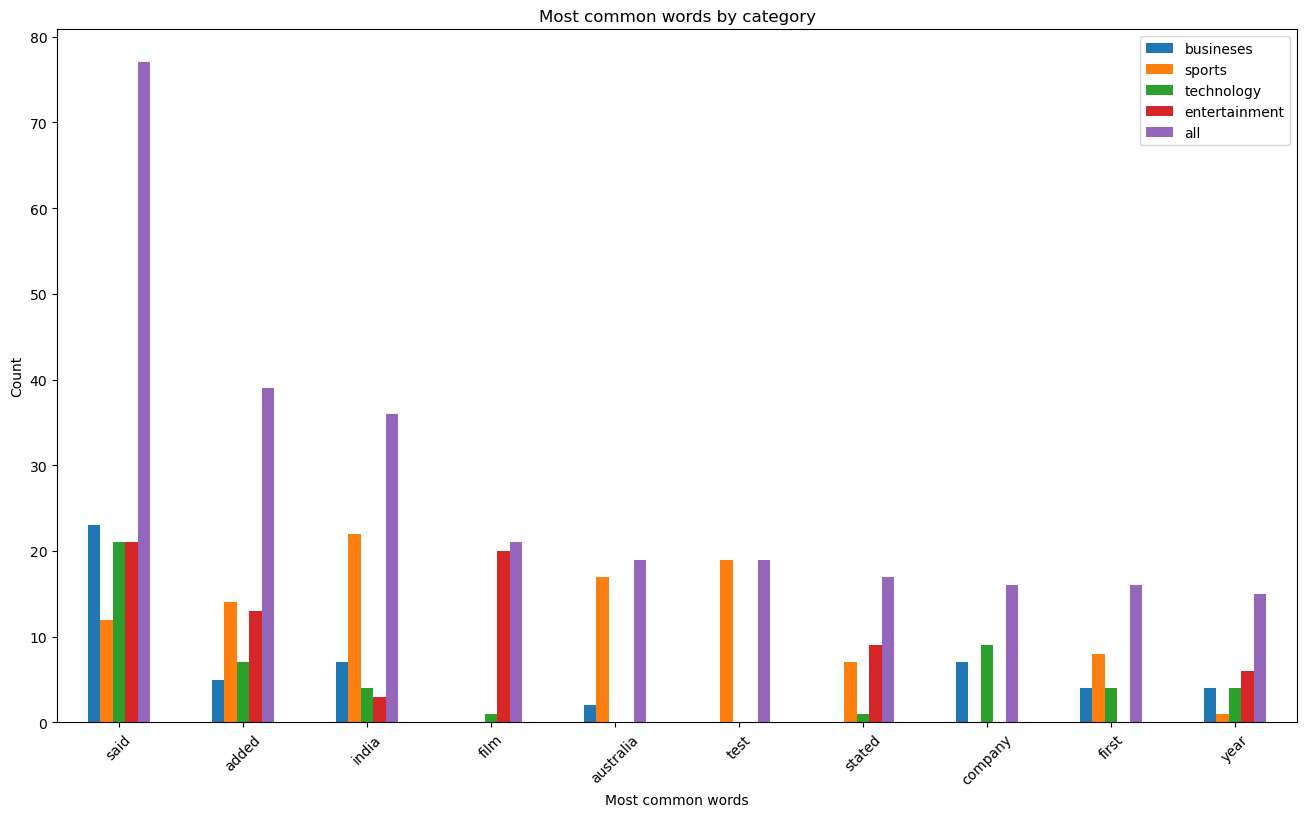

In [148]:
word_freq.sort_values('all', ascending=False).head(10).plot.bar(figsize=(16, 9))
plt.title('Most common words by category')
plt.ylabel('Count')
plt.xlabel('Most common words')
plt.xticks(rotation=45)
plt.show()

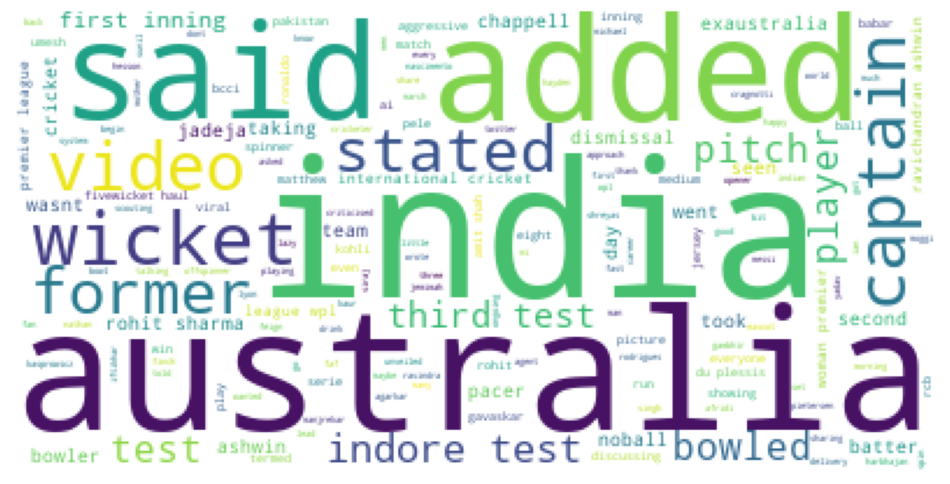

In [149]:
all_cloud = WordCloud(background_color='white').generate(' '.join(sports_words))
plt.figure(figsize=(12, 8))
plt.imshow(all_cloud)
plt.axis('off')
plt.show()

In [158]:
sports_bigrams = pd.Series(nltk.ngrams(sports_words, 2))
sports_bigrams.value_counts()

(indore, test)            7
(first, inning)           6
(third, test)             6
(test, australia)         5
(ravichandran, ashwin)    4
                         ..
(tweeted, mascot)         1
(mascot, resembles)       1
(resembles, tigress)      1
(tigress, seen)           1
(hed, added)              1
Length: 851, dtype: int64